In [44]:
# 本题要求在已知指数未来收益率的情况下，限制交易频率，最⼤化策略收益。
# 赛题背景
# 沪深300指数作为中国证券市场的重要指标，其变化直接影响着投资者的决策和市场情绪。该指数由沪
# 深两市市值⼤、流动性好的300只A股股票组成，⾃2005年4⽉发布以来，已成为衡量市场表现的关键
# ⼯具。沪深300指数的预测对于投资者理解市场趋势、制定投资策略具有重要意义。本赛题旨在通过数
# 学建模和数据分析 ，提⾼对沪深300指数未来⾛势的预测准确性，并在此基础上构建有效的交易策略。
# 本大题共分2个小题目，请依次作答。
# 赛题说明：
# • 交易规则设置：交易开始时仓位为0，每天的仓位上限是100单位，下限是0。每天最多买⼊或卖出
# 单位是10；
# • 优化⽬标：在满⾜交易限制的前提下，实现整个回测周期内最⼤化的收益；
# • 在策略设计中明确考虑交易限制，并解其对策略性能的影响；
# • 交易执⾏的时间点为每个交易⽇的收盘时间点，交易价格为收盘价；
# • 回测时间窗： 2020年1⽉2⽇⾄2023年12⽉29⽇。
# 提交结果要求：
# • 参赛者需提供策略在历史数据上的回测结果 ，包括累计收益、最⼤回撤、夏普⽐率等评估指标（指
# 标计算⽅法见附录）；
# • 提交策略的代码实现，以便评审能够复现优化结果。

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import datetime

In [46]:
# 设置样式
# 希望上涨用红色，下跌用绿色
# mpf_style = mpf.make_mpf_style(base_mpf_style='tradingview', rc={'font.family': 'SimHei'})
# mpf_style = mpf.make_mpf_style(base_mpf_style='tradingview', rc={'font.family': 'SimHei'}, marketcolors=mpf.make_marketcolors(up='red', down='green'))
# Volume的颜色不能没有
mpf_style = mpf.make_mpf_style(base_mpf_style='tradingview', rc={'font.family': 'SimHei'}, marketcolors=mpf.make_marketcolors(up='red', down='green', volume='in'))

In [ ]:
# # plot 显示中文
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

In [48]:
# B题数据\hs300.csv
data = pd.read_csv('hs300.csv')
data

,交易日期,开盘点位,最高点位,最低点位,收盘价,成交量(万股),成交额(万),涨跌幅(%)
0,2007-01-04,2073.25,2139.49,2054.24,2067.09,1067197.07,8238107.26,1.28
1,2007-01-05,2051.15,2083.40,2030.76,2072.88,927434.47,6802606.02,0.28
2,2007-01-08,2072.01,2131.74,2071.72,2131.56,847679.09,6630393.61,2.83
3,2007-01-09,2137.49,2201.36,2128.06,2200.09,815776.29,6545619.27,3.22
4,2007-01-10,2210.76,2255.97,2194.77,2255.97,849049.79,6882262.48,2.54
...,...,...,...,...,...,...,...,...
4128,2023-12-25,3330.33,3348.88,3330.33,3347.45,745426.93,12183832.71,0.31
4129,2023-12-26,3345.40,3345.42,3315.94,3324.79,747329.35,12168999.74,-0.68
4130,2023-12-27,3326.93,3341.27,3309.67,3336.36,944039.28,14092492.37,0.35
4131,2023-12-28,3335.56,3423.40,3331.21,3414.54,1480648.51,24585563.45,2.34


In [49]:
data['交易日期'] = pd.to_datetime(data['交易日期'])
data.set_index('交易日期', inplace=True)
data

,开盘点位,最高点位,最低点位,收盘价,成交量(万股),成交额(万),涨跌幅(%)
交易日期,,,,,,,
2007-01-04,2073.25,2139.49,2054.24,2067.09,1067197.07,8238107.26,1.28
2007-01-05,2051.15,2083.40,2030.76,2072.88,927434.47,6802606.02,0.28
2007-01-08,2072.01,2131.74,2071.72,2131.56,847679.09,6630393.61,2.83
2007-01-09,2137.49,2201.36,2128.06,2200.09,815776.29,6545619.27,3.22
2007-01-10,2210.76,2255.97,2194.77,2255.97,849049.79,6882262.48,2.54
...,...,...,...,...,...,...,...
2023-12-25,3330.33,3348.88,3330.33,3347.45,745426.93,12183832.71,0.31
2023-12-26,3345.40,3345.42,3315.94,3324.79,747329.35,12168999.74,-0.68
2023-12-27,3326.93,3341.27,3309.67,3336.36,944039.28,14092492.37,0.35


In [50]:
# data 的索引多了一个 “交易日期” 行，去掉


c:\Program Files\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


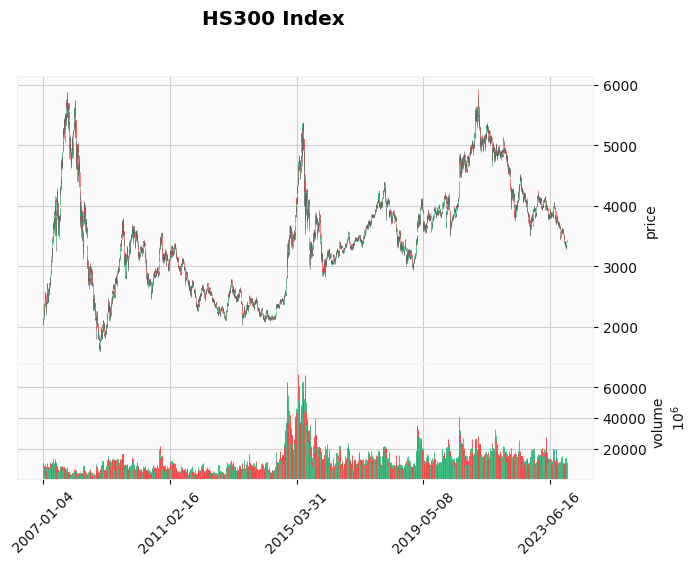

<Figure size 640x480 with 0 Axes>

In [52]:
# 使用 mplfinance 绘制 K 线图
data_price = data[['开盘点位', '最高点位', '最低点位', '收盘价']]
data_price.columns = ['open', 'high', 'low', 'close']
data_price = data_price.astype(float)
data_volume = data[['成交量(万股)', '成交额(万)']]
data_volume.columns = ['volume', 'amount']
data_volume = data_volume.astype(float)
data_volume['volume'] = data_volume['volume'] * 10000
data_volume['amount'] = data_volume['amount'] * 10000

data_price_and_volume = pd.concat([data_price, data_volume], axis=1)

# 绘制 K 线图
mpf.plot(data_price_and_volume, type='candle', volume=True, title='HS300 Index',
         ylabel='price', ylabel_lower='volume', style='yahoo', datetime_format='%Y-%m-%d',
         show_nontrading=False)
plt.savefig('hs300.png', dpi=300, bbox_inches='tight')
plt.show()